In [232]:
library(data.table)
library(factoextra)
library(ggplot2)
library(jpeg)

In [169]:
musk <- fread("C:/Users/erdem.banak/Documents/IE582/IE582Fall2019_data_files/HW2/Musk1.csv")

colnames(musk)[1:2] <- c("Class", "BagId")

I'll check how disperse the columns are:

In [96]:
differences <- data.table()

for (i in colnames(musk[, 3:168])){
  d <- musk[, .(ColName = i, Range = max(get(i)) - min(get(i)),
                StDev = sd(get(i)))]
  differences <- rbind(d, differences) 
}
 
summary(differences)


   ColName              Range           StDev       
 Length:166         Min.   :126.0   Min.   : 11.96  
 Class :character   1st Qu.:322.5   1st Qu.: 66.39  
 Mode  :character   Median :369.0   Median : 79.49  
                    Mean   :367.8   Mean   : 78.72  
                    3rd Qu.:419.0   3rd Qu.: 93.44  
                    Max.   :547.0   Max.   :132.99  

Everything is in the same scale (angstroms) and there is no drastic difference between the range of the columns. Standard deviation varies more than the mean and I want to keep that info. Therefore I won't be scaling the data. Also this will be a good example in showing the relation between MDS and PCA.

Number of items in a bag is shown below. There are some outliers; I have drawn an histogram without outliers too.

ItemCount,BagCount
2,32
3,4
4,31
5,6
6,2
8,11
9,2
16,1
32,1
40,2


[1] "There are 92 bags."
[1] "There are on average 5.17 items in each bag"


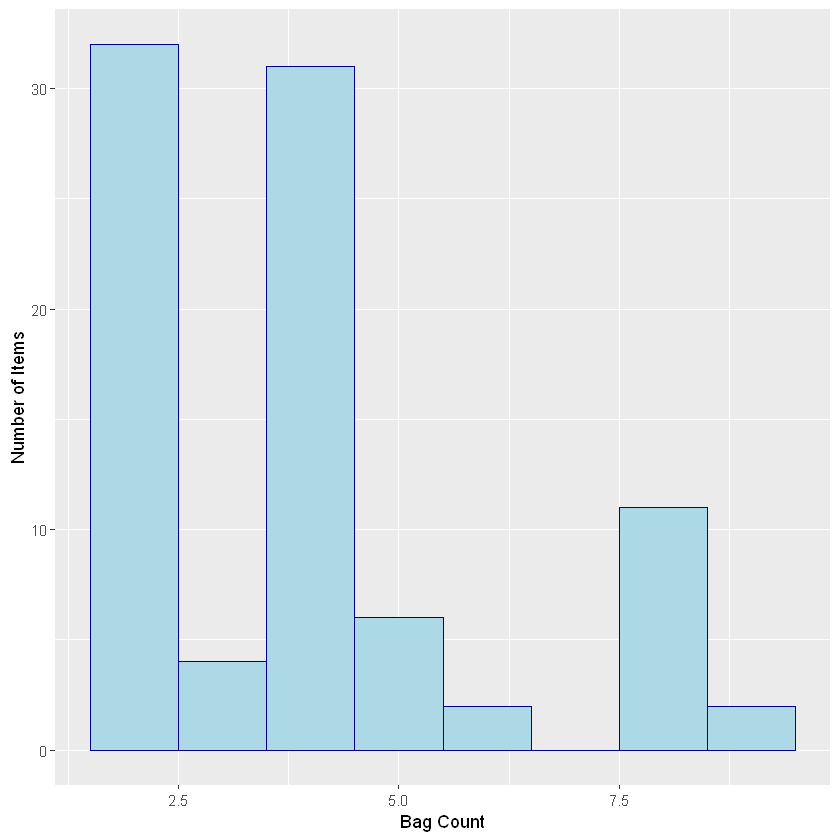

In [97]:
item_in_each_bag <- musk[, .(ItemCount = .N), BagId]
item_bag <- item_in_each_bag[, .(BagCount = .N), ItemCount][order(ItemCount)]

item_bag
print(paste0("There are ", nrow(item_in_each_bag), " bags."))
print(paste0("There are on average ", round(mean(item_in_each_bag[, ItemCount]), 2), " items in each bag"))

ggplot(item_in_each_bag[ItemCount < 10,], aes(x = ItemCount)) + 
  geom_histogram(color="darkblue", fill="lightblue", binwidth = 1) +
  labs(x="Bag Count", y = "Number of Items")

Since I won't be scaling the data and using covariance matrix for PCA, Torgerson MDS with Euclidean distance will give us the same solution with the PCA.

In [98]:
pca <- prcomp(musk[, 3:168])

components <- as.data.table(pca$x)

components_with_bags <- cbind(musk[, 1:2], components)

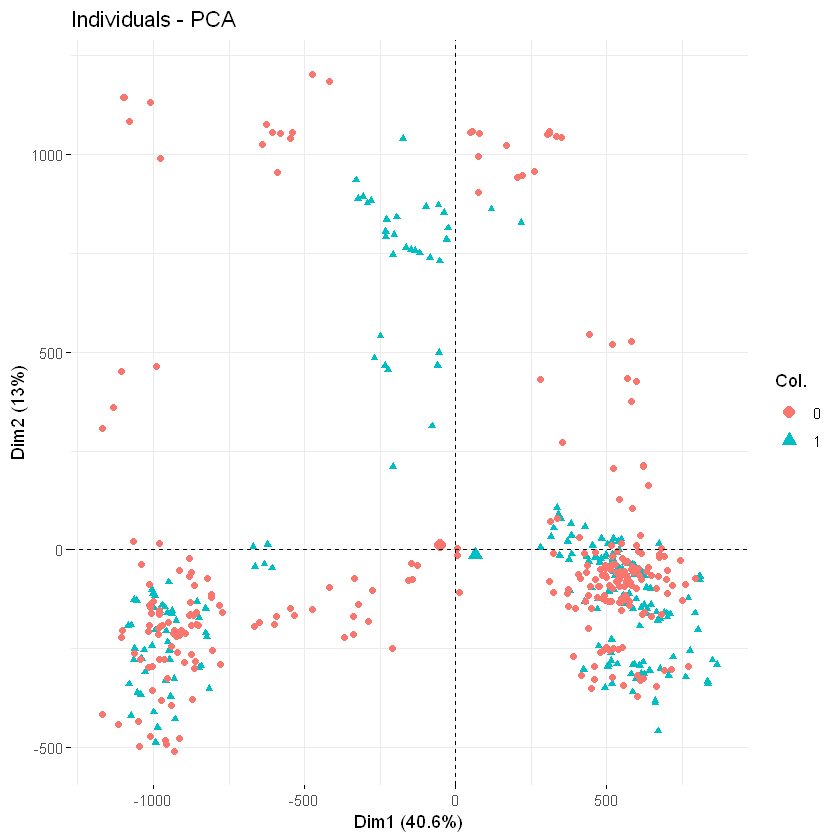

In [99]:
groups <- as.factor(musk[, Class])

fviz_pca_ind(pca,
             col.ind = groups, # color by groups
             # palette = c("#00AFBB",  "#FC4E07"),
             geom = "point")

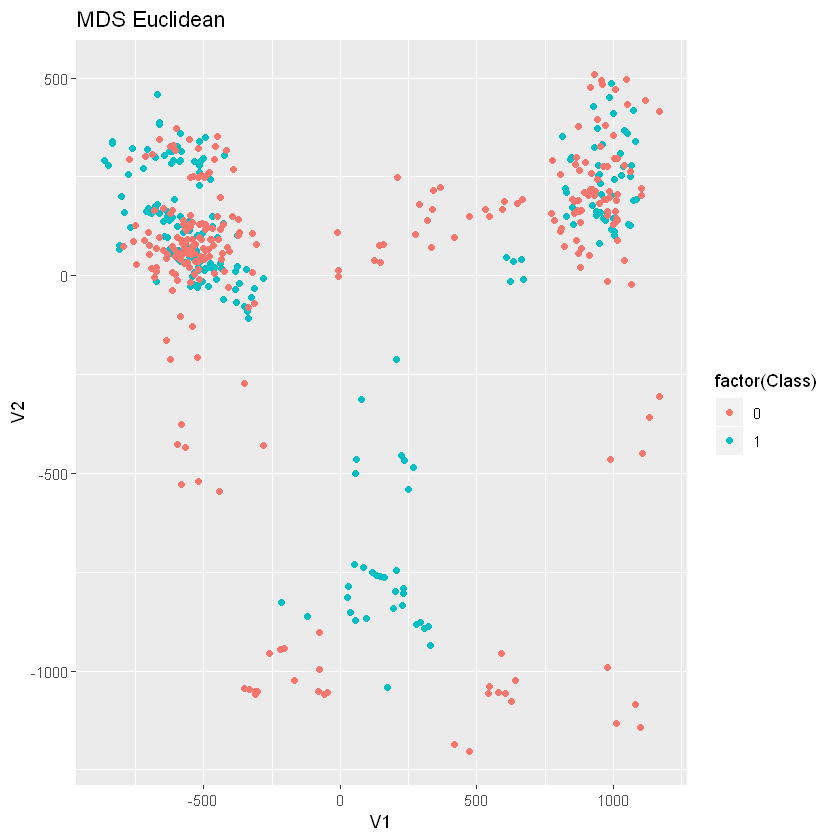

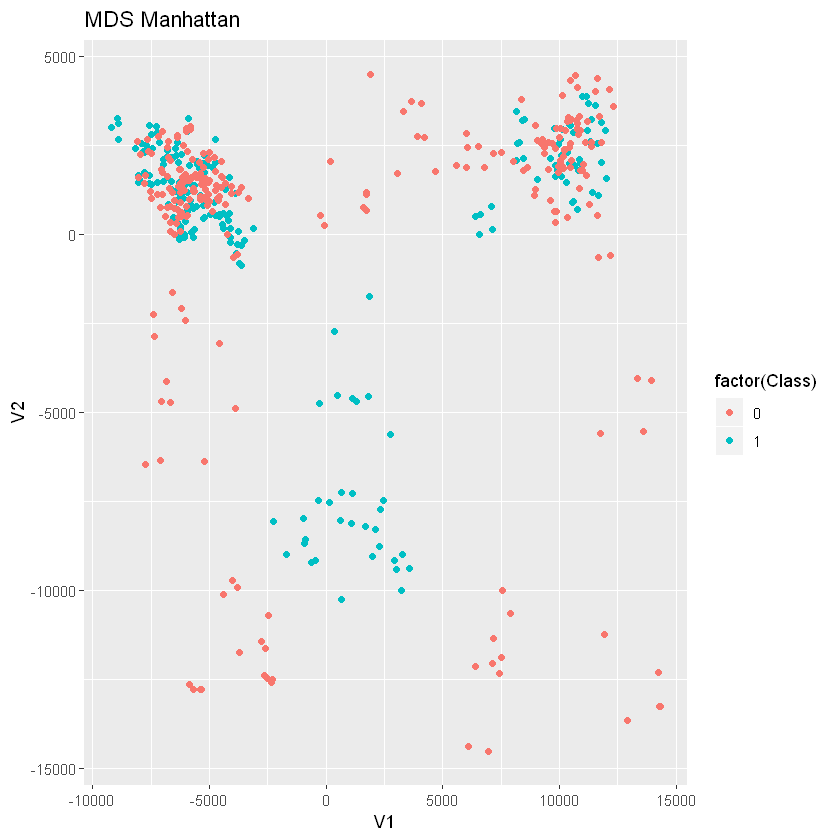

In [164]:
data <- musk[, 3:168]

distance <- dist(data)

mds <- data.table(cmdscale(distance))

mds_with_bags <- cbind(musk[, 1:2], mds)

ggplot(mds_with_bags, aes(x = V1, y = V2)) + geom_point(aes(color = factor(Class))) + labs(title = "MDS Euclidean") 

#

data <- musk[, 3:168]

distance <- dist(data, method = "manhattan")

mds <- data.table(cmdscale(distance))

mds_with_bags_mh <- cbind(musk[, 1:2], mds)

ggplot(mds_with_bags_mh, aes(x = V1, y = V2)) + geom_point(aes(color = factor(Class))) + labs(title = "MDS Manhattan") 

From below, you can see that axis values for PCA and MDS - Euclidean are same while for Manhattan it is different.

In [167]:
print("PCA Components")
summary(components_with_bags[, 1:4])

print("MDS - Euclidean")
summary(mds_with_bags)

print("MDS - Manhattan")
summary(mds_with_bags_mh)

[1] "PCA Components"


     Class            BagId            PC1               PC2         
 Min.   :0.0000   Min.   : 1.00   Min.   :-1170.1   Min.   :-509.96  
 1st Qu.:0.0000   1st Qu.:29.00   1st Qu.: -843.0   1st Qu.:-206.17  
 Median :0.0000   Median :56.50   Median :  384.1   Median :-100.90  
 Mean   :0.4349   Mean   :52.39   Mean   :    0.0   Mean   :   0.00  
 3rd Qu.:1.0000   3rd Qu.:81.00   3rd Qu.:  560.2   3rd Qu.: -10.57  
 Max.   :1.0000   Max.   :92.00   Max.   :  865.3   Max.   :1203.56  

[1] "MDS - Euclidean"


     Class            BagId             V1               V2          
 Min.   :0.0000   Min.   : 1.00   Min.   :-865.3   Min.   :-1203.56  
 1st Qu.:0.0000   1st Qu.:29.00   1st Qu.:-560.2   1st Qu.:   10.57  
 Median :0.0000   Median :56.50   Median :-384.1   Median :  100.90  
 Mean   :0.4349   Mean   :52.39   Mean   :   0.0   Mean   :    0.00  
 3rd Qu.:1.0000   3rd Qu.:81.00   3rd Qu.: 843.0   3rd Qu.:  206.17  
 Max.   :1.0000   Max.   :92.00   Max.   :1170.1   Max.   :  509.96  

[1] "MDS - Manhattan"


     Class            BagId             V1              V2          
 Min.   :0.0000   Min.   : 1.00   Min.   :-9196   Min.   :-14515.6  
 1st Qu.:0.0000   1st Qu.:29.00   1st Qu.:-6132   1st Qu.:   385.2  
 Median :0.0000   Median :56.50   Median :-4308   Median :  1419.2  
 Mean   :0.4349   Mean   :52.39   Mean   :    0   Mean   :     0.0  
 3rd Qu.:1.0000   3rd Qu.:81.00   3rd Qu.: 8927   3rd Qu.:  2259.2  
 Max.   :1.0000   Max.   :92.00   Max.   :14321   Max.   :  4497.1  

You can see how much variance is explained by the each PCA component below. It doesn't look good since we need around 9 eigenvectors for explaining 80% of the error:

[1] "We need 9 eigenvectors to explain 80% of the variance"

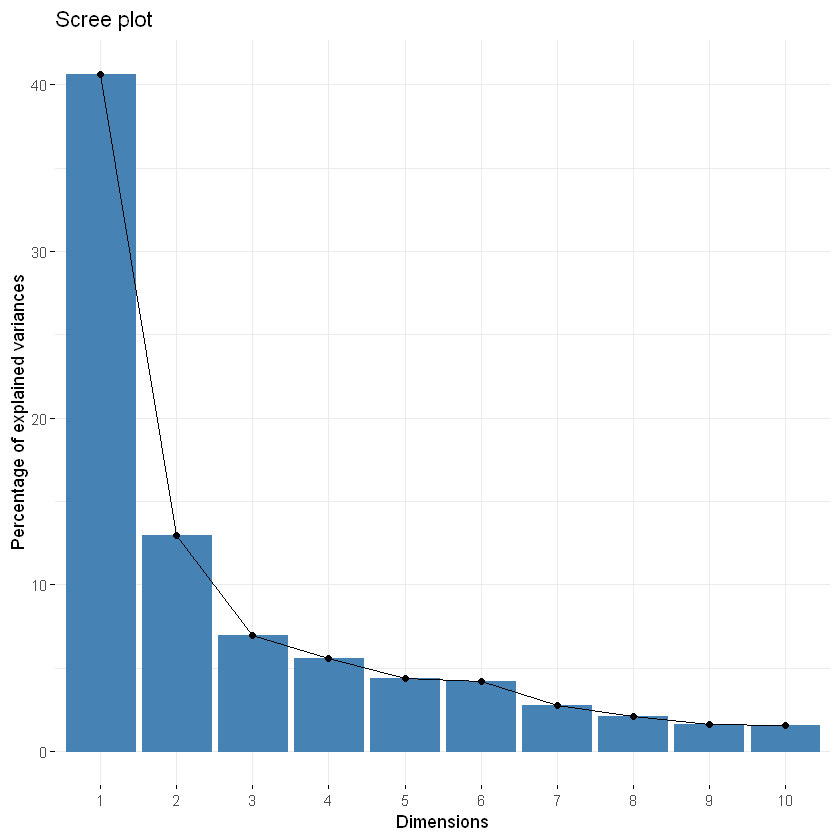

In [181]:
fviz_eig(pca)

cumpro <- cumsum(pca$sdev^2 / sum(pca$sdev^2))
paste0("We need ", length(cumpro[cumpro < 0.8]) + 1, " eigenvectors to explain 80% of the variance")

In the first part, our aim is understanding the effect of labeling instances with bags. The question suggests using mapping the instances in the PCA with the labels. From above, you can see that there is not much distinction between the labels in the 2 dimensions. There are 2 possible reasons for that.

1 - Labels might be completely random or don't have a linear relationship with the features; therefore even if first 2 dimensions explained us the variance in the data it might not be enough for understanding the label. PCA won't automatically help us in understanding the label clusters. Remember, PCA or MDS does not care about the labels.

2 - In multi instance learning problems, there are multiple ways of labeling the bag; for example it might be focusing on a key item; which means if bag contains a positive item, bag is considered positive. Therefore, we should also be careful about this too.

Since the problem looks to be more about the second part; I have investigated how instances in the bags are mapped across the first 2 dimensions. From the summary below you can see that many bags are nearly spanning the dimension 1 axis. If bags are dispersed around the dimensions we can say that our assumption of giving same tags to all instances in a bag might be problematic:

In [184]:
comps12 <- components_with_bags[, .(BagId, Class, PC1, PC2)]

comps12[, `:=`(Max1 = max(PC1),
               Min1 = min(PC1),
               Max2 = max(PC2),
               Min2 = min(PC2),
               ItemCount = .N), BagId]

comps12[, `:=`(Range1 = max(PC1) - min(PC1),
               Range2 = max(PC2) - min(PC2))]
               
comp <- comps12[, .(Diff1 = mean(Max1 - Min1)/mean(Range1),
                    Diff2 = mean(Max2 - Min2)/mean(Range2)), .(BagId, Class, ItemCount)]


comp[, .(BagCount = .N, Diff1 = mean(Diff1), Diff2  = mean(Diff2)), ItemCount]

ItemCount,BagCount,Diff1,Diff2
4,31,0.2265074,0.05052068
2,32,0.2282045,0.03571494
3,4,0.3883179,0.05495321
5,6,0.7025132,0.10277417
6,2,0.7419243,0.19978379
8,11,0.5754054,0.15112048
9,2,0.7861427,0.19016083
32,1,0.8886684,0.27784468
40,2,0.9178749,0.28504650
16,1,0.1695193,0.19732952


It is possible to see that there are many bags spanning the 50% of the whole axis along the dimension 1.

You might check an example from below. You can see that some elements are on the left side and some are on the right side. Also remember that 3rd and 4th quantiles were quite mixed on labels:

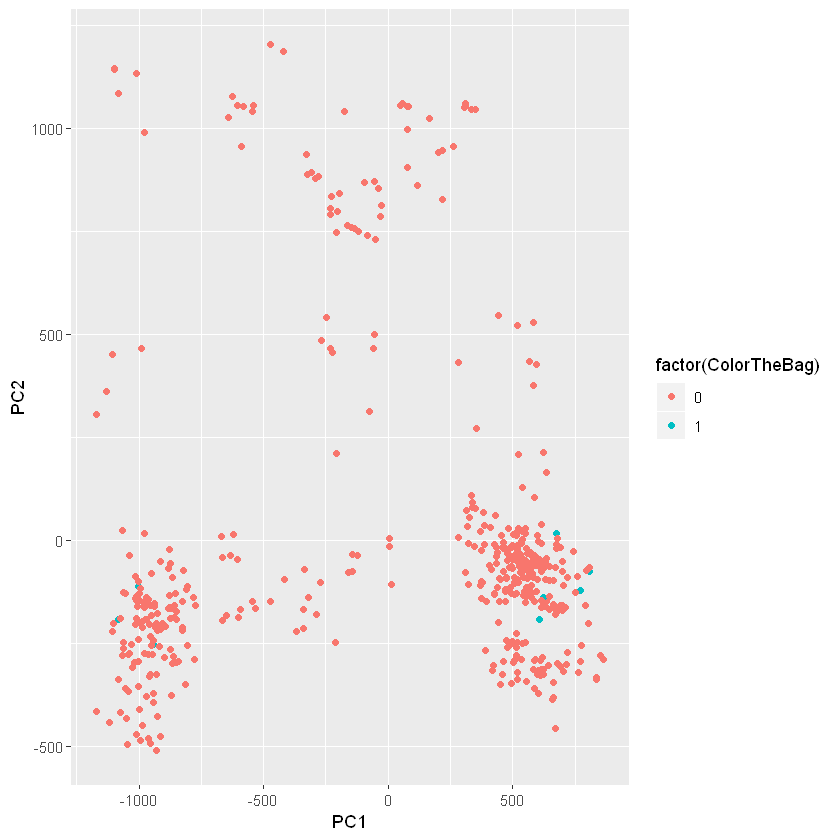

In [185]:
# PCA

components_with_bags[, ColorTheBag := ifelse(BagId == 12, 1, 0)]

ggplot(components_with_bags, aes(x=PC1, y = PC2)) + 
  geom_point(aes(color = factor(ColorTheBag)))


If we are not mapping the instances in the bag closer using PCA; it won't be easy to use PCA for understanding how labels are distributed. Therefore, I would say that our assumption of instance labels being same as the bag labels is not a good assumption.

# 1b

For this example, I am scaling the data, therefore MDS and PCA results will slightly differ from now on. I will calculate PCA results by using the mean of the data in this part.

Also to understand which was better in identifying positive and negative labels, I have made up a metric. It is based on the metric we are using in k-means; between-SS/total-SS. With that, we will have something more to rely on when comparing how labels are mapped in the PCA axis.

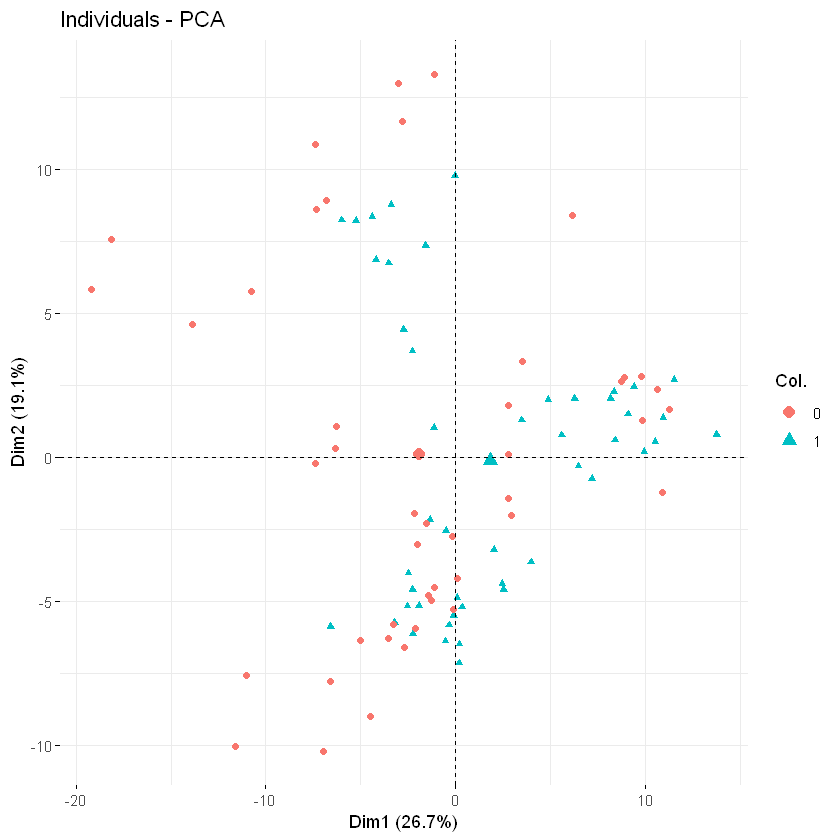

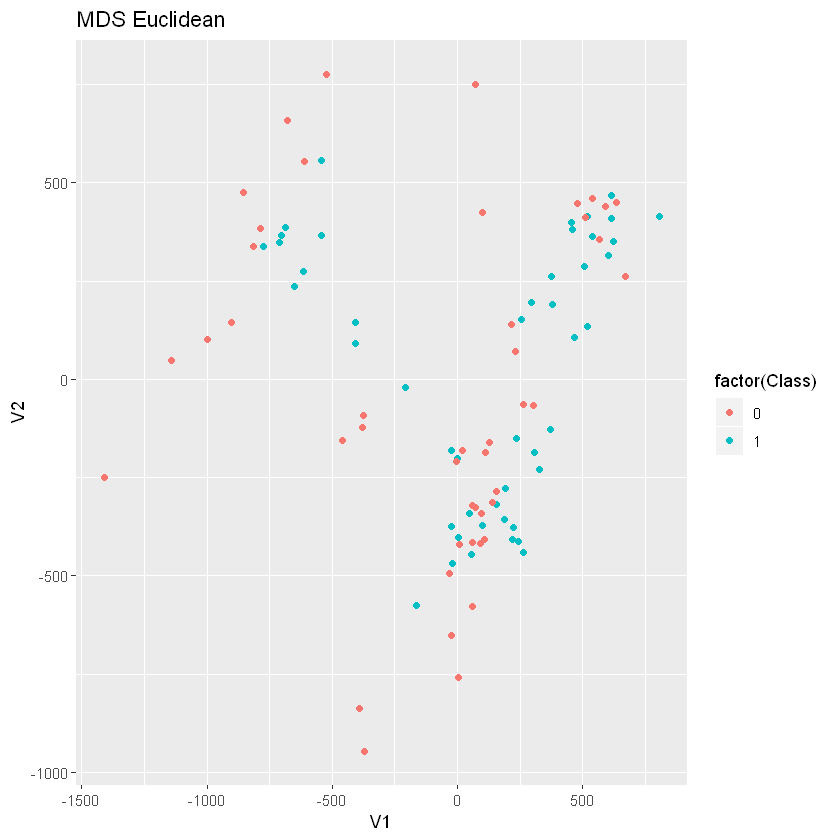

[1] "We need 7 eigenvectors to explain 80% of the variance"

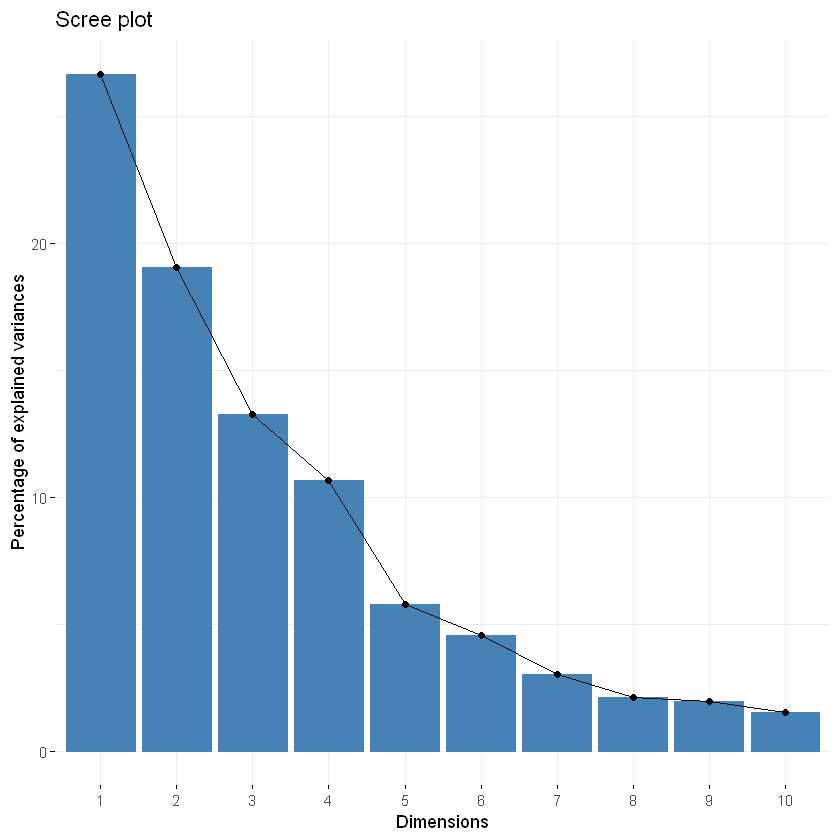

In [190]:
musk_means <- musk[, lapply(.SD, mean), .(Class, BagId)]

pca_mean <- prcomp(musk_means[, 3:168], scale. = T)

components_mean <- as.data.table(pca_mean$x)

components_mean_with_bags <- cbind(musk_means[, 1:2], components_mean)

groups <- as.factor(musk_means[, Class])

fviz_pca_ind(pca_mean,
             col.ind = groups, # color by groups
             # palette = c("#00AFBB",  "#FC4E07"),
             geom = "point")

data <- musk_means[, 3:168]

distance <- dist(data)

mds_mean <- data.table(cmdscale(distance))

mds_mean_with_bags <- cbind(musk_means[, 1:2], mds_mean)

ggplot(mds_mean_with_bags, aes(x = V1, y = V2)) + geom_point(aes(color = factor(Class))) + labs(title = "MDS Euclidean") 

fviz_eig(pca_mean)

cumpro <- cumsum(pca_mean$sdev^2 / sum(pca_mean$sdev^2))
paste0("We need ", length(cumpro[cumpro < 0.8]) + 1, " eigenvectors to explain 80% of the variance")

We need 7 eigenvectors for the 80% of the variance now. Also classes look to be a little bit more diverse now.

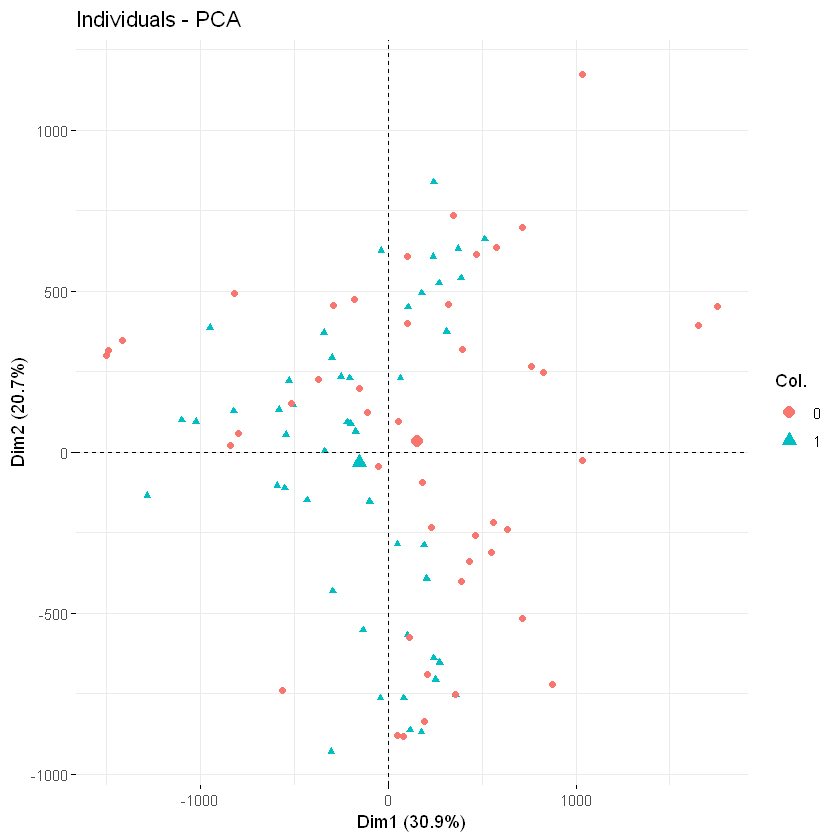

In [158]:
musk_max <- musk[, lapply(.SD, max), .(Class, BagId)]

pca_max <- prcomp(musk_max[, 3:168], scale. = T)

components_max <- as.data.table(pca_max$x)

components_max_with_bags <- cbind(musk_max[, 1:2], components_max)

groups <- as.factor(musk_max[, Class])

fviz_pca_ind(pca_max,
             col.ind = groups, # color by groups
             # palette = c("#00AFBB",  "#FC4E07"),
             geom = "point")


From this point on, we will work on different ways of summarizing the bags. For understanding which representation works better in terms of understanding the labels, I have come up with a made-up metric.

I will use the 2 dimensions of the PCA to understand how labels are distributed. In k-means algorithm we were checking between-ss/total-ss ratio; I will use it to understand goodness of the representation in terms of clustering similar labels together.

If between-ss/total-ss ratio is high; it would mean that the similar labels are clustered together.

We might have used a logistic regression with 2 features and calculate the performance but we are not using any supervised learning approach.

In [191]:
betweentotalratio <- function(data, indexstart = 3, indexend = 4){
    total_variation <- 0
    ss_sum <- 0
    clusters <- unique(data[, Class])
    
    columns <- colnames(data[, indexstart:indexend])
    for (j in columns){
        for (i in clusters){
            rows_comp <- nrow(data[Class == i])
            rows <- nrow(data)
    
            ss <- var(data[Class == i, get(j)])*(rows_comp-1)
            ss_sum <- ss_sum + ss
          }
        total_variation <- total_variation + var(data[, get(j)])*(rows-1)
  }
    
    return (round(1 - ss_sum/total_variation, 3))
    
}

In [228]:
for (i in 1:3){
    print(paste0("First part, first ", i+1, " components", " explains ", betweentotalratio(components_with_bags, 3, i+3)))
}

for (i in 1:3){
    print(paste0("Using means, first ", i+1, " components", " explains ", betweentotalratio(components_mean_with_bags, 3, i+3)))
}

for (i in 1:3){
    print(paste0("Using max, first ", i+1, " components", " explains ", betweentotalratio(components_max_with_bags, 3, i+3)))
}

[1] "First part, first 2 components explains 0.001"
[1] "First part, first 3 components explains 0.002"
[1] "First part, first 4 components explains 0.021"
[1] "Using means, first 2 components explains 0.048"
[1] "Using means, first 3 components explains 0.093"
[1] "Using means, first 4 components explains 0.08"
[1] "Using max, first 2 components explains 0.043"
[1] "Using max, first 3 components explains 0.08"
[1] "Using max, first 4 components explains 0.071"


Looks like using means of the components are giving more diverse labels. Using 3 components to plot while using means will give us the best approach among top. The performance difference is huge.

# 1c

In the upper section, I have shown using max of the components as a possible way. It is easy to generate more on same vein; min etc. Another possible way of creating the features for a bag might be using the features from PCA of all instances. We can again use mean - max. I will be just showing max.

In [223]:
spec_c <- components_with_bags[, lapply(.SD, max), .(Class, BagId)]

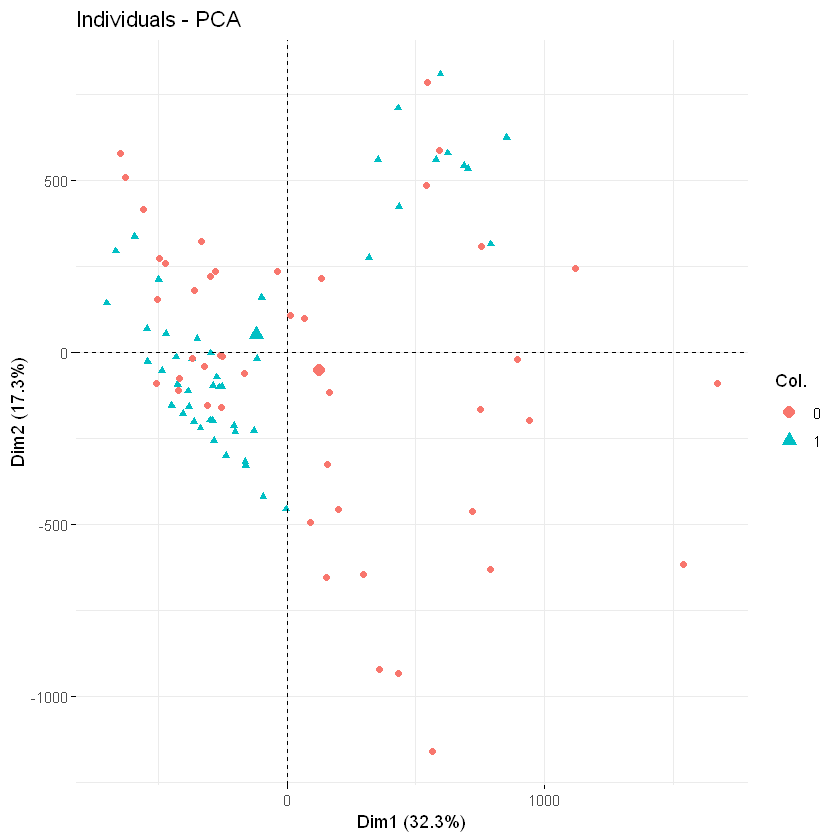

[1] "We need 9 eigenvectors to explain 80% of the variance"

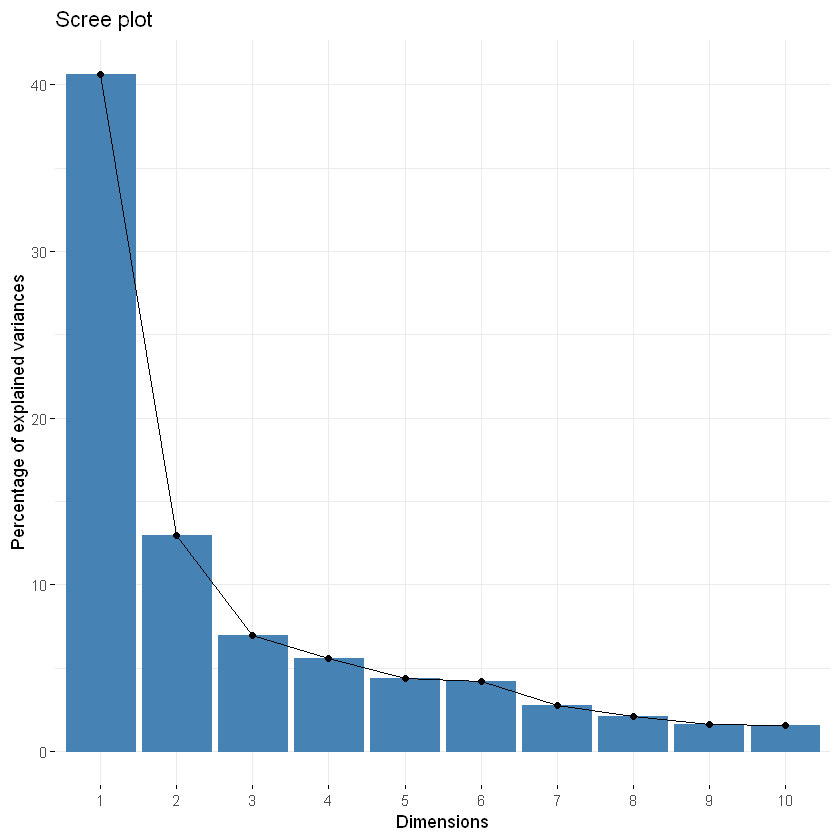

In [227]:
pca_max <- prcomp(spec_c[, 3:168])

components_max <- as.data.table(pca_max$x)

components_max_with_bags <- cbind(musk_max[, 1:2], components_max)

groups <- as.factor(musk_max[, Class])

fviz_pca_ind(pca_max,
             col.ind = groups, # color by groups
             # palette = c("#00AFBB",  "#FC4E07"),
             geom = "point")

fviz_eig(pca)

cumpro <- cumsum(pca$sdev^2 / sum(pca$sdev^2))
paste0("We need ", length(cumpro[cumpro < 0.8]) + 1, " eigenvectors to explain 80% of the variance")

We can see the 4th quartile only consists of red dots; which shows us we are on the right track.

In [226]:
for (i in 1:3){
    print(paste0("Using max of PCA comps, first ", i+1, " components", " explains ", betweentotalratio(components_max_with_bags, 3, i+3)))
}

[1] "Using max of PCA comps, first 2 components explains 0.043"
[1] "Using max of PCA comps, first 3 components explains 0.08"
[1] "Using max of PCA comps, first 4 components explains 0.071"


Item count in a bag might be a column in the feature vector too.

In [155]:
components_with_bags[, .(ItemCount = .N), .(BagId, Class)][, .N, .(Class, ItemCount)][order(ItemCount, Class)]

Class,ItemCount,N
0,2,22
1,2,10
0,3,1
1,3,3
0,4,13
1,4,18
1,5,6
1,6,2
0,8,3
1,8,8


Regarding the metric, it kind of aims to find the maximum distance between different labels. It works on 2-steps and it will probably be a mess to optimize.

Therefore I checked the literature about the problem. As expected, one of them (Sun, Yu Yin, 2010) was using multi-instance logistic regression for calculating the performance of different dimensionality reduction techniques and calculating the AUROC. My metric was more about trying to find out how separate the classes were with the lower dimensional data.

Still, it uses a metric which would act similar to my made-up metric to use in the optimization problem:

1 - Aim is discriminating the negative and positive bags easily

2 - Assumes key (positive) instance decides the bag's label.

3 - Minimize the squared loss of posterior probability (posterior prob can be estimated through Naive Bayes etc.)

4 - Which means, maximize the distance between key instance and negative instances

The dimension reduction algorithm makes use of the label of the bag; which wasn't the case for the PCA.

Another article (Wei, 2014) maps the bags using Fisher vector. Even though I don't know much about Fisher kernel, looks like the basis assumption of the papers are different. Fisher kernels are used in computer vision; therefore we wouldn't be assuming "key instance decides the bag's label" in this paper. It assumes instances in bags are independently and identically distributed but doesn't focus on a key instance.

* Sun, Yu-Yin, Michael K. Ng, and Zhi-Hua Zhou. "Multi-instance dimensionality reduction." Twenty-Fourth AAAI Conference on Artificial Intelligence. 2010.
* Wei, Xiu-Shen, Jianxin Wu, and Zhi-Hua Zhou. "Scalable multi-instance learning." 2014 IEEE International Conference on Data Mining. IEEE, 2014.

# 2a

 num [1:256, 1:256, 1:3] 0.294 0.388 0.255 0.192 0.231 ...


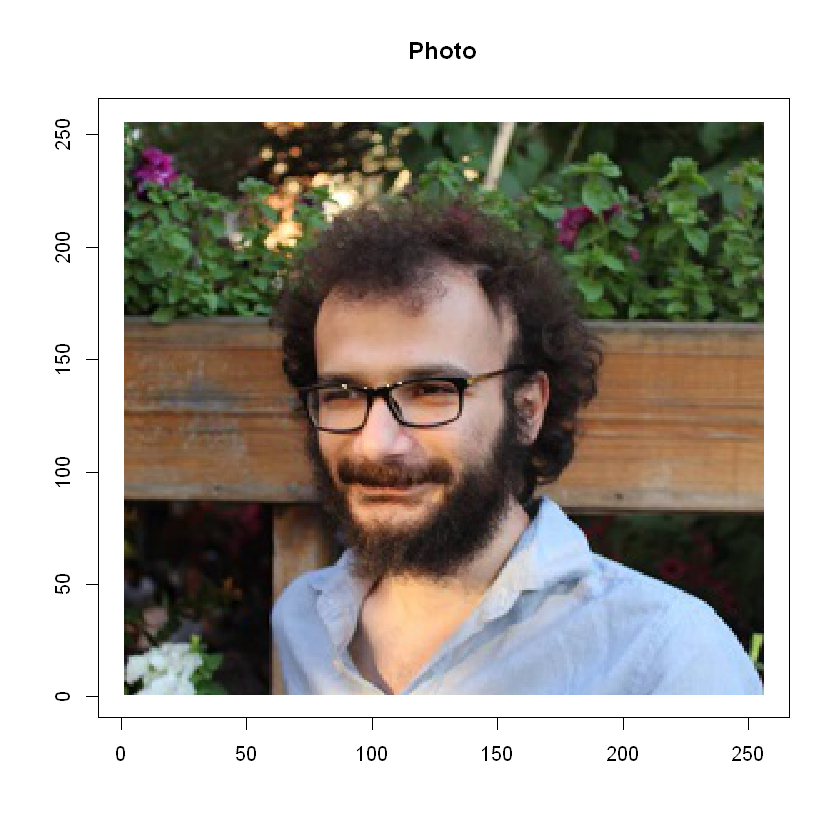

In [233]:
library(jpeg)

photo <- readJPEG("C:/Users/erdem.banak/Documents/IE582/Photo.jpg")

str(photo)

plot(c(1, 256), c(1, 256), type = "n", xlab = "", ylab = "", 
     main = "Photo")
rasterImage(photo, 1, 1, 256, 256, angle = 0, interpolate = FALSE)


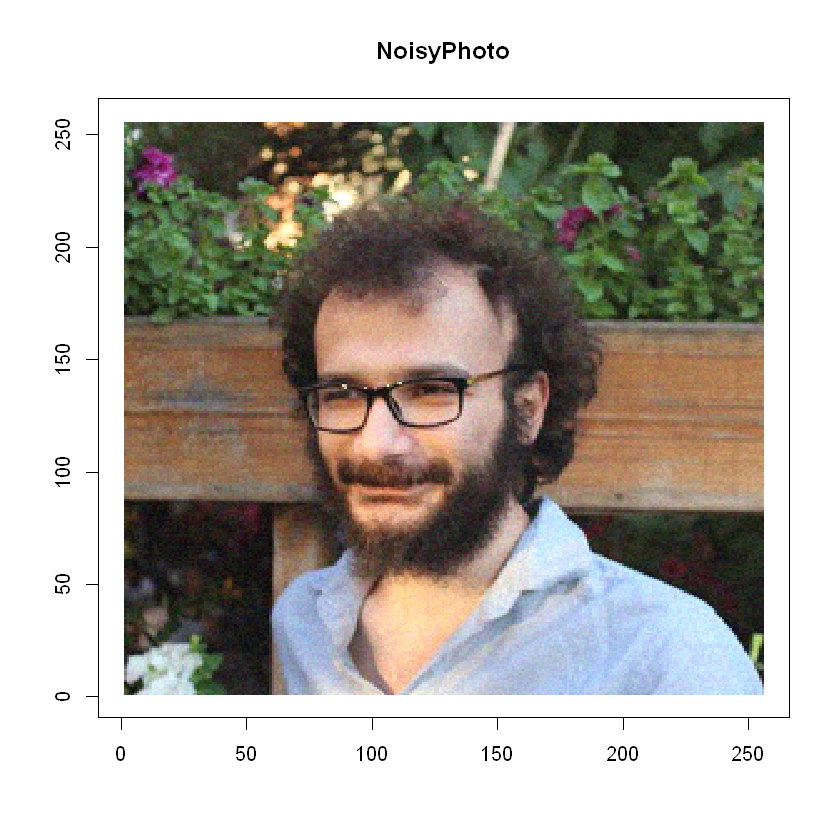

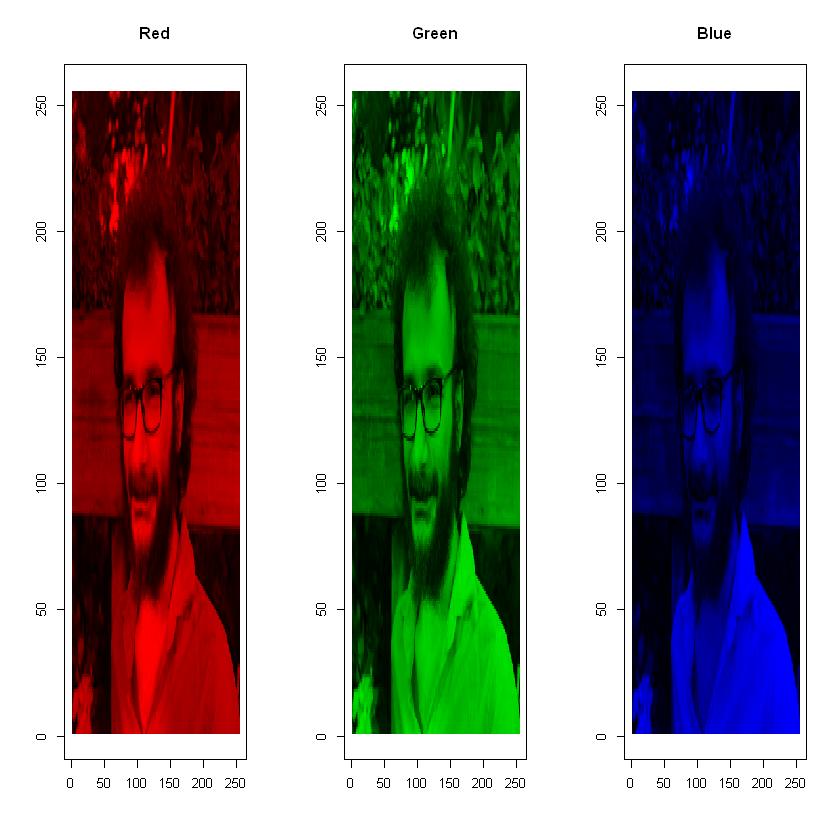

In [235]:
min_val <- min(photo)
max_val <- max(photo)

noise <- array(runif(256*256*3, min_val, max_val*0.1), c(256,256,3))

# Pixel value cannot be more than 1
noisy <- photo + noise
noisy[noisy > 1] <- 1

plot(c(1, 256), c(1, 256), type = "n", xlab = "", ylab = "", 
     main = "NoisyPhoto")
rasterImage(noisy, 1, 1, 256, 256, angle = 0, interpolate = FALSE)

# Colors
i = 1

par(mfrow = c(1, 3))
channels <- data.table(c = 1:3, Color = c("Red", "Green", "Blue")) 

for (i in 1:3){
  ch <- channels[i, Color]
  ph <- array(0, c(256,256,3))
  ph[,,i] <- photo[,,i]
  plot(c(1, 256), c(1, 256), type = "n", xlab = "", ylab = "", 
       main = ch)
  rasterImage(ph, 1, 1, 256, 256, angle = 0, interpolate = FALSE)
}


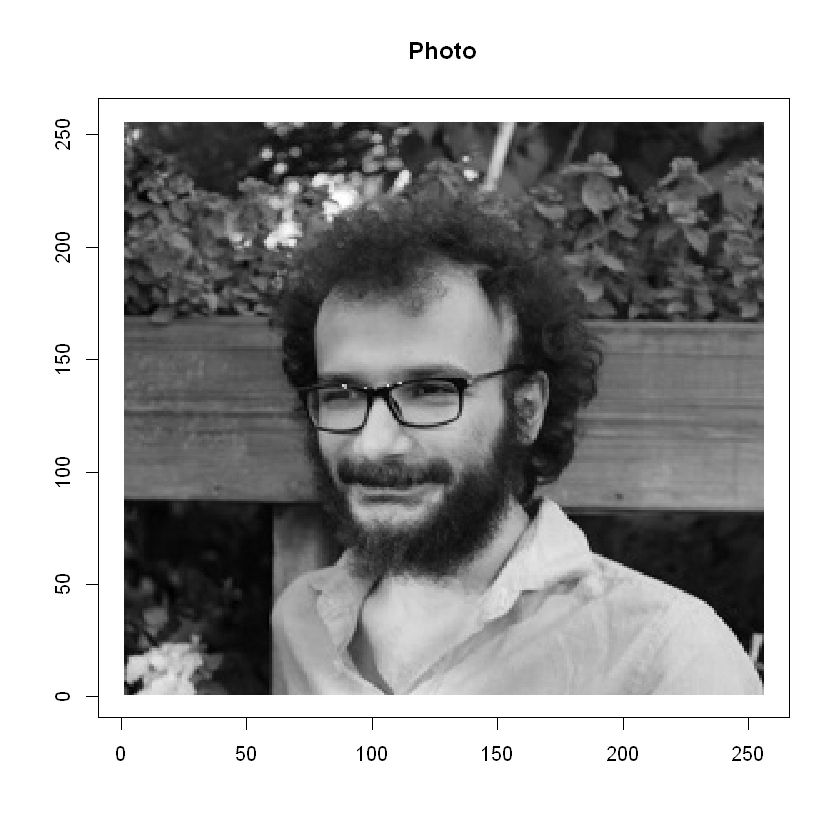

In [249]:
# ITU-R Grayscale
# I couldn't find a good function in R to turn into grayscale; so I converted manually

greyscale = 0.2126*photo[,,1] + 0.7152*photo[,,2] + 0.0722*photo[,,3]
par(mfrow = c(1, 1))

plot(c(1, 256), c(1, 256), type = "n", xlab = "", ylab = "", 
     main = "Photo")
rasterImage(greyscale, 1, 1, 256, 256, angle = 0, interpolate = FALSE)

# 3a

[1] "We need 9 eigenvectors to explain 80% of the variance"

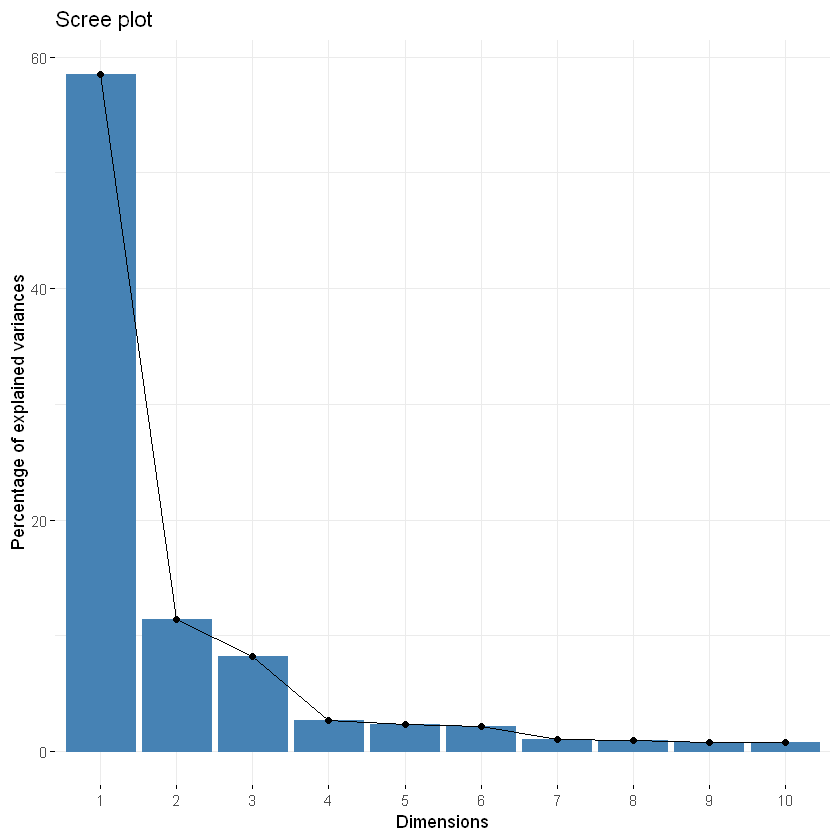

In [241]:
pca_dt <- data.table()

k <- 1
comb_list <- list()

for (i in 1:(256-24)){
  for (j in 1:(256-24)){
    patch <- as.vector(greyscale[i:(i+24), j:(j+24)])
    comb_list[[k]] <- patch
    k = k + 1
  } 
}

pca_dt <- transpose(as.data.table(array(unlist(comb_list), dim=c(625, 232*232))))

gr_pca <- princomp(pca_dt, scores = TRUE)

fviz_eig(gr_pca)

gr_sc <- gr_pca$scores

paste0("We need ", length(cumpro[cumpro < 0.8]) + 1, " eigenvectors to explain 80% of the variance")

Compared with the first part, the first eigenvalue has a greater explanatory power in this example. It explains nearly 60% of the variance. Since the rest of the eigenvalues have less impact, we need 7 eigenvalues for explaining the 80% of the variance. 

# 3b

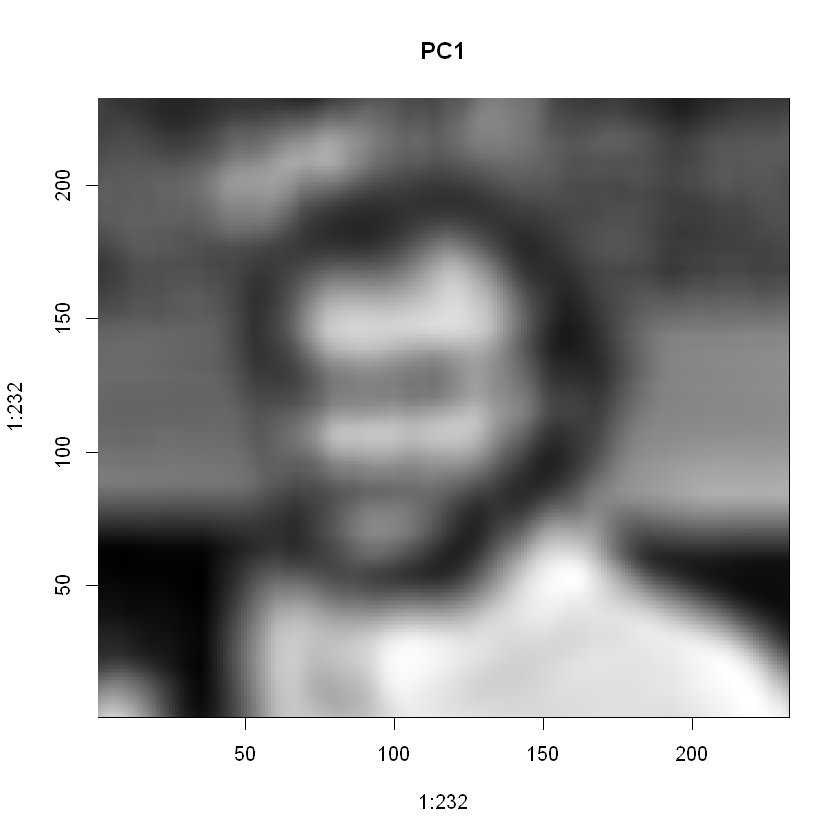

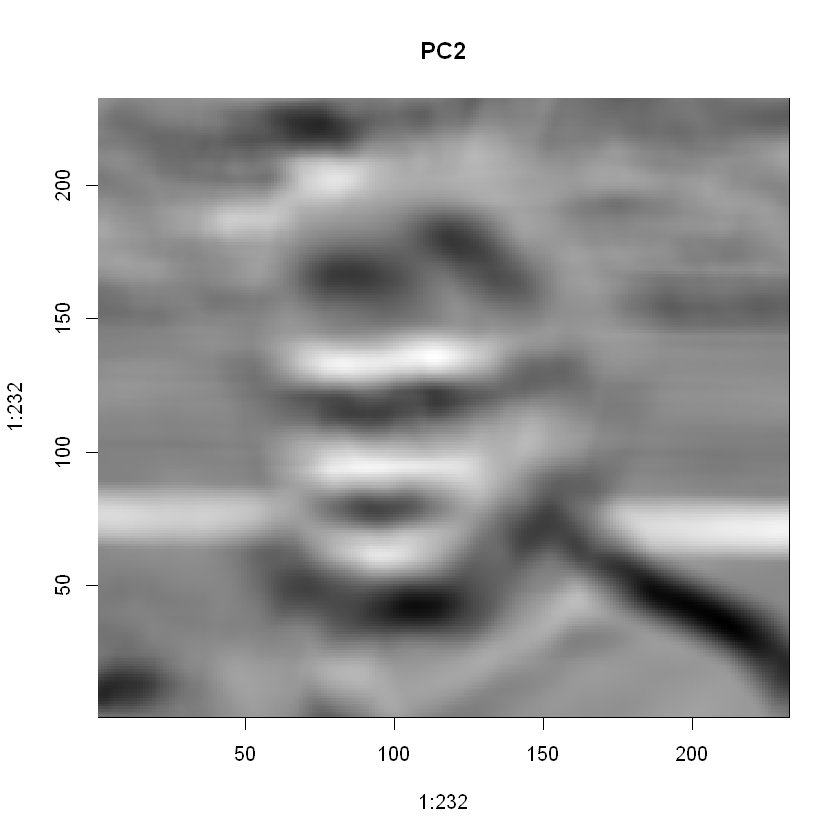

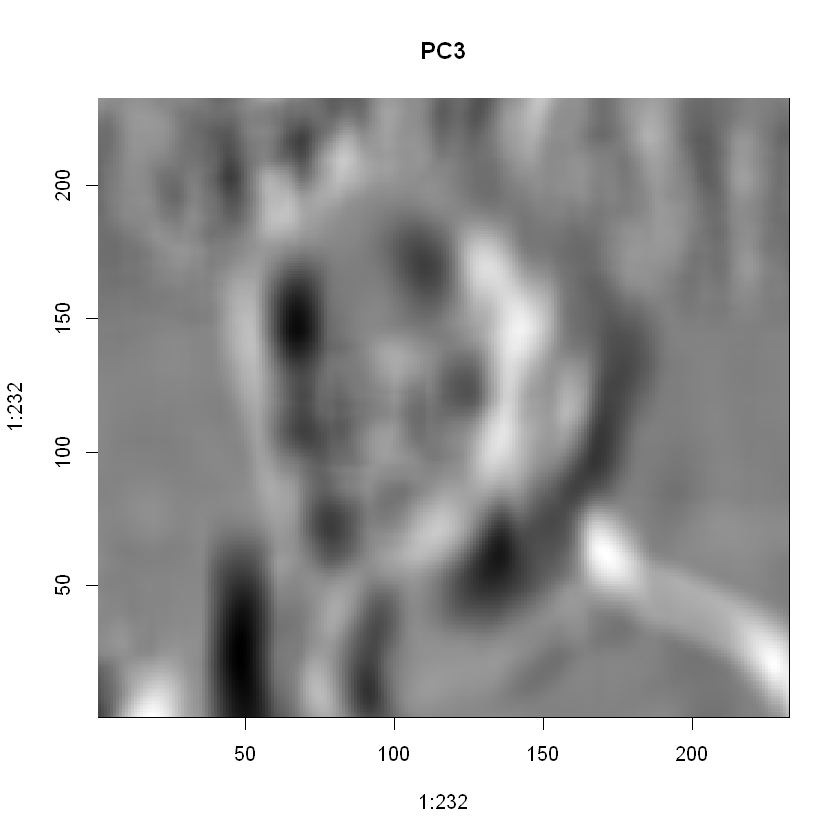

In [240]:
comp_gr <- as.data.table(gr_pca$scores)

comp <- matrix(as.vector(comp_gr$Comp.1), nrow = 232, ncol = 232, byrow = TRUE)
image(1:232, 1:232, t(comp[ncol(comp):1, ]), 
      col = gray((0:255)/255), main = "PC1")

comp <- matrix(as.vector(comp_gr$Comp.2), nrow = 232, ncol = 232, byrow = TRUE)
image(1:232, 1:232, t(comp[ncol(comp):1, ]), 
      col = gray((0:255)/255), main = "PC2")

comp <- matrix(as.vector(comp_gr$Comp.3), nrow = 232, ncol = 232, byrow = TRUE)
image(1:232, 1:232, t(comp[ncol(comp):1, ]), 
      col = gray((0:255)/255), main = "PC3")



As expected, first principal component gave the best approximation of the original image. For all of the images above, we are compressing the image to 1/625th size.

# 3c

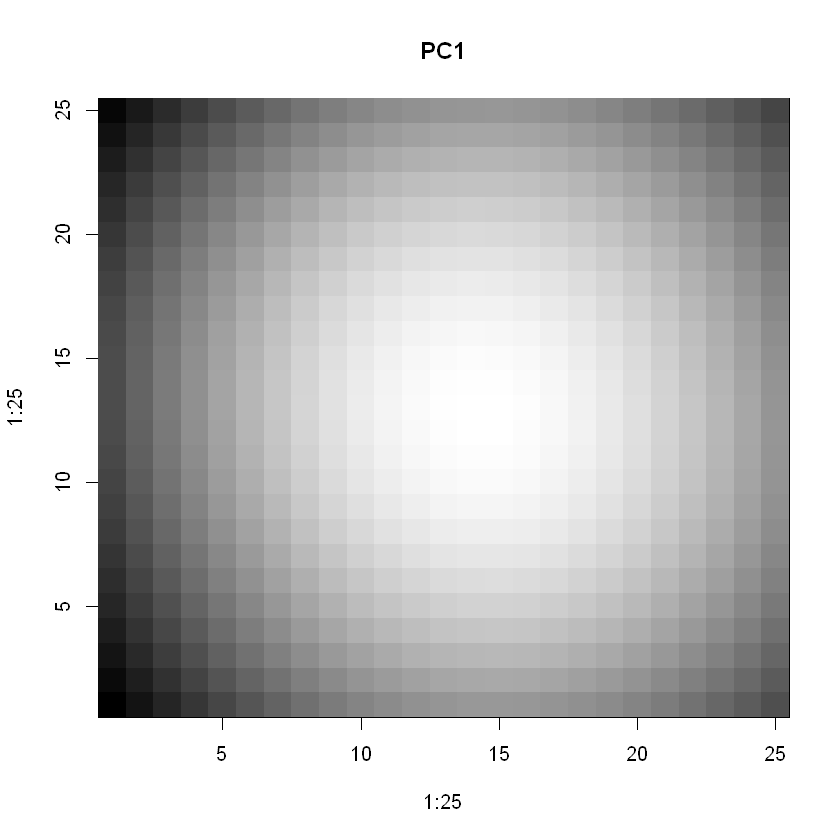

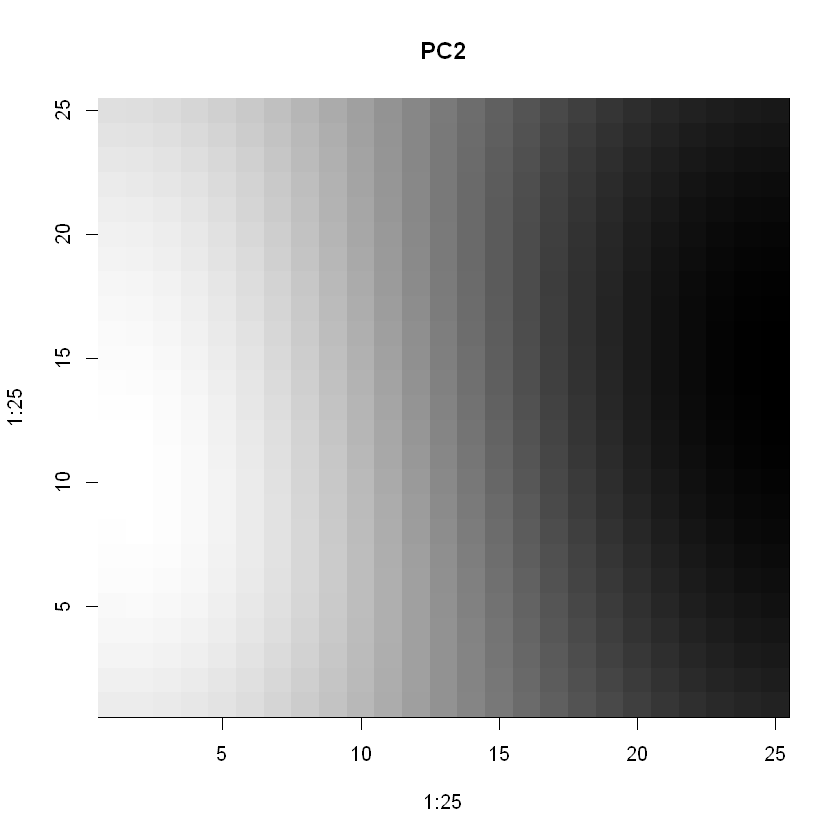

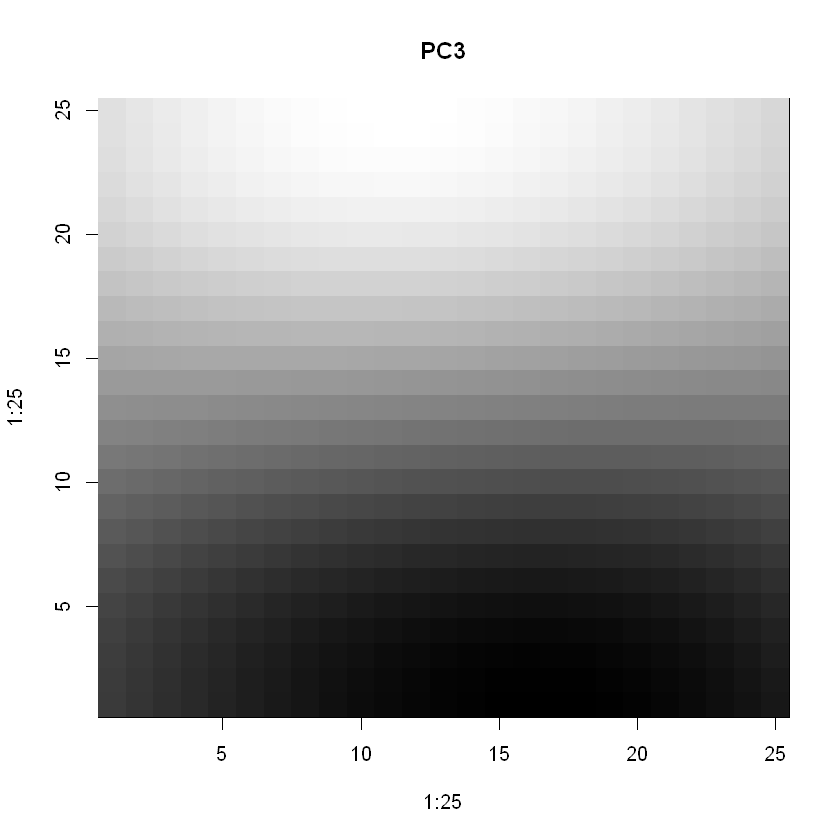

In [248]:
eig_vecs <- as.data.table(loadings(gr_pca)[])

eig1 <- eig_vecs[, Comp.1]
eig <- matrix(eig1, nrow = 25, ncol = 25, byrow = TRUE)
image(1:25, 1:25, t(eig[ncol(eig):1, ]), 
      col = gray((0:255)/255), main = "PC1")

eig2 <- eig_vecs[, Comp.2]
eig <- matrix(eig2, nrow = 25, ncol = 25, byrow = TRUE)
image(1:25, 1:25, t(eig[ncol(eig):1, ]), 
      col = gray((0:255)/255), main = "PC2")

eig3 <- eig_vecs[, Comp.3]
eig <- matrix(eig3, nrow = 25, ncol = 25, byrow = TRUE)
image(1:25, 1:25, t(eig[ncol(eig):1, ]), 
      col = gray((0:255)/255), main = "PC3")


I would expect a photo with first component like this to be brighter on the middle but I am not sure about this interpretation.